In [1]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize

# seeds for replicability but are not needed here unless you want
# the same results every time
# SEED = 23                       
# np.random.seed(SEED)
# random.seed(SEED)
# pnp.random.seed(SEED) 

import warnings
warnings.filterwarnings('ignore')


In [2]:
##############################################################################
# 1) Define devices:  noiseless ("default.qubit"),  noisy ("default.mixed").
##############################################################################

# noiseless device
dev_exact = qml.device("default.qubit", wires = 2, shots = None)

# niosy device (simple amplitude + phase damping model)
# "shots=1024" is used so we can mimic a finite-sample experiment.
dev_noisy = qml.device(
    "default.mixed",
    wires = 2,
    shots = 1024)

# try:
#     dev_noisy.rng = np.random.default_rng(SEED)
# except AttributeError:
#     pass 

In [3]:
##############################################################################
# 2) Define the H2 Hamiltonian, the ansatz, and nuclear repulsion shift.
##############################################################################

# H2 Hamiltonian coefficients
coeffs = {
    'c0': -1.0523732,
    'c1':  0.39793742,
    'c2': -0.3979374,
    'c3': -0.0112801,
    'c4':  0.18093119
}
# Nuclear repulsion shift for H2 at R=0.75 A
nuclear_repulsion = 0.7199689944489797

# place coefficients in list for easier access
coefs_list = [
    coeffs['c0'],
    coeffs['c1'],
    coeffs['c2'],
    coeffs['c3'],
    coeffs['c4']
]
ops_list = [
    qml.Identity(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliZ(0)   @ qml.Identity(1),
    qml.PauliZ(0)   @ qml.PauliZ(1),
    qml.PauliX(0)   @ qml.PauliX(1)
]
H = qml.Hamiltonian(coefs_list, ops_list)

In [4]:
# ansatz with two parameters repeated to some "circuit_depth".
def ansatz(params, circuit_depth=2, gamma=0.1, phi=0.1, noisy=False):
    """
        Applies RY-RZ layers plus CNOTs, optionally inserting amplitude & phase damping on both wires if noisy method is selected.
        'gamma' and 'phi' set the damping rates for amplitude and phase damping, respectively.
    """
    theta1, theta2 = params

    # initial single-qubit gates
    for w in range(2):
        qml.RY(theta1, wires=w)
        qml.RZ(theta1, wires=w)

    if noisy:
        # amplitude & phase damping with user-defined gamma, phi
        qml.AmplitudeDamping(gamma, wires=0)
        qml.PhaseDamping(phi, wires=1)

    # repeated pattern: chain of CNOTs + single-qubit rotations
    for _ in range(circuit_depth):
        qml.CNOT(wires=[0, 1])
        for w in range(2):
            qml.RY(theta2, wires = w)
            qml.RZ(theta2, wires = w)

In [5]:
# We define a QNode that takes 'scale_factor' to scale the amplitude/phase damping
# For example, gamma = 0.1*scale_factor, phi = 0.1*scale_factor
@qml.qnode(dev_noisy)
def circuit_noisy_scaled(params, circuit_depth = 2, scale_factor=  1.0):
    gamma = 0.1 * scale_factor
    phi   = 0.1 * scale_factor
    ansatz(params, circuit_depth=circuit_depth, gamma=gamma, phi = phi, noisy = True)
    return qml.expval(H)

In [6]:
##############################################################################
# 3) define QNodes and cost functions for exact, noisy, and CDR runs.
##############################################################################

@qml.qnode(dev_exact)
def circuit_exact(params, circuit_depth = 2):
    ansatz(params, circuit_depth = circuit_depth, noisy = False)
    return qml.expval(H)

@qml.qnode(dev_noisy)
def circuit_noisy(params, circuit_depth=2):
    ansatz(params, circuit_depth = circuit_depth, noisy = True)
    return qml.expval(H)

def cost_exact(params, circuit_depth = 2):
    return circuit_exact(params, circuit_depth=circuit_depth) + nuclear_repulsion

def cost_noisy(params, circuit_depth=2, scale_factor = 1.0):
    return circuit_noisy_scaled(params, circuit_depth=circuit_depth, scale_factor=scale_factor) + nuclear_repulsion


In [7]:
##############################################################################
# 4) random near-Clifford circuit generation for training.
##############################################################################

def random_clifford_params(params, snap_prob = 0.3):
    """
        with probability 'snap_prob' per angle, snap it to the nearest multiple of pi/2,
        making it effectively a Clifford rotation. otherwise keep original angle.
    """
    out = []
    for angle in params:
        if np.random.rand() < snap_prob:
            # snap to multiple of pi/2
            # we'll pick whichever multiple of pi/2 is nearest, or pick randomly:
            # multiples of pi/2 in [0, 2π) are: 0, π/2, π, 3π/2
            # you can also choose from -∞,∞ but mod 2π. we do mod 2π:
            angle_mod_2pi = angle % (2*np.pi)
            multiples = np.array([0., np.pi/2, np.pi, 3*np.pi/2])
            # find whichever of these is nearest
            diffs = np.abs(multiples - angle_mod_2pi)
            idx = np.argmin(diffs)
            # we then re-insert the integer multiple, but keep same quadrant shift from original
            snapped_val = multiples[idx]  # This is in [0, 2π)
            # we can either just take snapped_val or do angle - angle_mod_2pi + snapped_val
            # so we preserve the same "2π offset" as the original. usually it doesn't matter
            # because angles are periodic
            base = angle - angle_mod_2pi
            out.append(base + snapped_val)
        else:
            # keep original
            out.append(angle)
    return np.array(out)

In [8]:
SCALE_FACTORS  = [1.0, 1.3, 1.5]
POOL_SIZE      = 1000
CIRCUIT_DEPTH  = 2

# select random seed so same circuits are picked for all models
# this is to make sure that it is not randomly picked at each iteration of the optimization
np.random.seed(23)                       
train_pool = [random_clifford_params(
                  np.random.uniform(0, 2*np.pi, size = 2),   
                  snap_prob = 0.3)
              for _ in range(POOL_SIZE)]

def generate_cdr_training_data(params, n_train = 50, circuit_depth = 2):
    """
        Draw 'n_train' circuits without replacement from the global pool
        (wrap-around if needed).  Guarantees that every optimisation call
        sees reproducible training samples.
    """
    global pool_idx
    idx = np.arange(pool_idx, pool_idx + n_train) % POOL_SIZE
    # advance the cursor
    pool_idx = (pool_idx + n_train) % POOL_SIZE        

    # initialize the list for storing the data
    X_noisy, Y_exact = [], []
    # loop over each selected circuit parameter from the training pool
    for cparams in (train_pool[i] for i in idx):
        # evaluate the "ideal" expectation value (i.e., noise free result)
        E_exact = cost_exact(cparams, circuit_depth = circuit_depth)
        # evaluate noisy expectation values at different noise scales
        # these form the features for training the regression model
        noisy_vec = [cost_noisy(cparams, circuit_depth = circuit_depth,
                                scale_factor=sf)
                     for sf in SCALE_FACTORS]
        X_noisy.append(noisy_vec)
        Y_exact.append(E_exact)
    # convert the training inputs and targets into NumPy arrays for model training
    return np.asarray(X_noisy, float), np.asarray(Y_exact, float)

pool_idx = 0 

In [9]:
# ------------------------------------------------------------------
# define lasso (by finding the best performing model)
# ------------------------------------------------------------------

def lasso_cv_regressor(x, y, random_state=42):
    # define a range of regularization strengths (alphas) on a log scale
    alphas = np.logspace(-4, 0, 30)
    
    # create a pipeline that:
    # 1. standardizes the input features (zero mean, unit variance)
    # 2. fits a lasso regression model with cross-validation to select the best alpha
    model = make_pipeline(
        StandardScaler(),
        LassoCV(
            alphas=alphas,            # list of alpha values to try
            cv=5,                     # 5-fold cross-validation
            max_iter=20000,           # max iterations for convergence
            tol=1e-5,                 # convergence tolerance
            random_state=random_state # ensures reproducible results
        )
    )

    # fit the pipeline on the input data (x = features, y = targets)
    model.fit(x, y)

    # return the trained model
    return model


# ------------------------------------------------------------------
# unified CDR predictor
# ------------------------------------------------------------------
def cdr_model(x_noisy, y_exact, x_test,
              model = "linear", alpha = 0.1,
              rf_n_estimators = 200, rf_max_depth = None,
              random_state = 0):

    # choose / build regressor
    if model == "lasso":
        # lasso_cv_regressor already includes scaling and is fitted here
        reg = lasso_cv_regressor(x_noisy, y_exact, random_state = random_state)

    else:
        # scale the features before fitting (not needed for lasso pipeline)
        scaler = StandardScaler()
        xs = scaler.fit_transform(x_noisy)
        x_test_ = scaler.transform([x_test])

        if model == "linear":
            reg = LinearRegression()

        elif model == "ridge":
            reg = Ridge(alpha = alpha, max_iter = 10000, tol = 1e-4)

        elif model in ("rf", "random_forest"):
            reg = RandomForestRegressor(
                n_estimators = rf_n_estimators,
                max_depth = rf_max_depth,
                random_state = random_state,
                n_jobs = 1
            )
        else:
            raise ValueError(f"unknown model '{model}'")

        # fit model and predict on scaled input
        reg.fit(xs, y_exact)
        return reg.predict(x_test_)[0]

    # if we're here we used the lasso-cv pipeline (which handles its own scaling)
    return reg.predict([x_test])[0]

In [10]:
##############################################################################
# 5) define cost function that uses cdr mitigation on each iteration.
##############################################################################

# replace the old signature with the one below (only 3 new characters!)
def cost_cdr(params,
             circuit_depth = 2,
             n_train = 10,
             model = "linear",
             alpha = 0.1,
             **model_kwargs):  # allows extra arguments for the model

    # 1) generate near‑clifford training data
    x_noisy, y_exact = generate_cdr_training_data(
        params,
        n_train = n_train,
        circuit_depth = circuit_depth
    )

    # 2) noisy measurements of this circuit at each scale factor
    test_noisy_vector = np.array([
        cost_noisy(params, circuit_depth = circuit_depth, scale_factor = sf)
        for sf in scale_factors
    ])

    # 3) mitigate
    e_cdr = cdr_model(
        x_noisy, y_exact, test_noisy_vector,
        model = model,
        alpha = alpha,
        **model_kwargs
    )

    return e_cdr


In [11]:
# store iteration histories
history_exact = []
history_noisy = []
history_cdr_linear = []
history_cdr_ridge = []
history_cdr_lasso = []
history_cdr_rf = []

# optimization parameters ("initial guess")
init_params = np.array([np.pi/2, np.pi/2])
circuit_depth = 2
maxiter = 10000

In [12]:
##############################################################################
# 6) Run three separate optimizations: exact, noisy, and CDR.
##############################################################################

# callback functions simply record the energies at each iteration
def cb_exact(xk):
    history_exact.append(cost_exact(xk, circuit_depth = circuit_depth))

def cb_noisy(xk):
    history_noisy.append(cost_noisy(xk, circuit_depth = circuit_depth))

def cb_cdr_linear(xk):
    # callback for the linear cdr regression
    val = cost_cdr(xk, circuit_depth = circuit_depth, n_train = 200, model = "linear")
    history_cdr_linear.append(val)

def cb_cdr_ridge(xk):
    # callback for the ridge cdr regression
    val = cost_cdr(xk, circuit_depth = circuit_depth, n_train = 200,
                   model = "ridge", alpha = 0.01)
    history_cdr_ridge.append(val)

def cb_cdr_lasso(xk):
    # callback for the lasso cdr regression
    val = cost_cdr(xk, circuit_depth = circuit_depth, n_train = 200,
                   model = "lasso", alpha = 0.001)
    history_cdr_lasso.append(val)

def cb_cdr_rf(xk):
    # callback for the random forest cdr regression
    val = cost_cdr(
        xk,
        circuit_depth   = circuit_depth,
        n_train         = 200,
        model           = "rf",
        rf_n_estimators = 300,
        rf_max_depth    = None
    )
    history_cdr_rf.append(val)

## Exact optimization

In [13]:
# 6a) exact optimization
res_exact = minimize(
    fun = lambda x: cost_exact(x, circuit_depth=circuit_depth),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_exact,
    options = {"maxiter": maxiter, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   43   F =-7.631186E-01    MAXCV = 0.000000E+00
   X = 2.237621E+00   1.394551E+00


## Noisy optimization

In [14]:
# 6b) Noisy optimization
res_noisy = minimize(
    fun = lambda x: cost_noisy(x, circuit_depth=circuit_depth),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_noisy,
    options = {"maxiter": maxiter, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   28   F =-6.912310E-01    MAXCV = 0.000000E+00
   X = 2.319923E+00   1.538420E+00


## CDR Optimizatoin

In [15]:
# 6c) CDR optimization
#    (We do the entire optimization using the cost_cdr function, 
#    so the training data is re-generated at each iteration.)
res_cdr_linear = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth = circuit_depth, n_train = 50, model = "linear", alpha = 0.0),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_linear,
    options = {"maxiter": 28, "disp": True}
)

# 6d) CDR-Ridge
res_cdr_ridge = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth = circuit_depth, n_train = 50, model = "ridge", alpha = 0.01),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_ridge,
    options = {"maxiter": 28, "disp": True}
)


# 6e) CDR-Lasso
res_cdr_lasso = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth = circuit_depth, n_train = 50, model = "lasso", alpha = 0.001),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_lasso,
    options = {"maxiter": 28, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   28   F =-6.695152E-01    MAXCV = 0.000000E+00
   X = 2.321724E+00   1.550873E+00

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   28   F =-7.146355E-01    MAXCV = 0.000000E+00
   X = 2.138453E+00   1.502189E+00

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   28   F =-7.424944E-01    MAXCV = 0.000000E+00
   X = 2.176630E+00   1.467856E+00


## Smooth line plotting

In [17]:
##############################################################################
# 7.1) helper: single optimisation run
##############################################################################
def optimise_single(model_type,                
                    init_params,
                    circuit_depth = 2,
                    n_train = 50,
                    alpha = 0.01,
                    maxiter = 1000,
                    **model_kwargs):
    # launch one cobyla vqe optimisation with cdr mitigation of the given type
    # returns the full energy history list for that run

    # run-local history list
    history = []

    # pick the right callback for this model
    def callback(xk):
        val = cost_cdr(
            xk,
            circuit_depth = circuit_depth,
            n_train = n_train,
            model = model_type,
            alpha = alpha,
            **model_kwargs,
        )
        history.append(val)

    # run the optimiser
    _ = minimize(
        fun = lambda params: cost_cdr(
            params,
            circuit_depth = circuit_depth,
            n_train = n_train,
            model = model_type,
            alpha = alpha,
            **model_kwargs,
        ),
        x0 = init_params,
        method = "COBYLA",
        callback = callback,
        options = {"maxiter": maxiter, "disp": False},
    )
    return np.asarray(history, dtype = float)

##############################################################################
# 7.2) helper: run many times and average
##############################################################################

def multi_run_average(model_type,
                      n_runs = 5,
                      init_params = np.array([np.pi / 2, np.pi / 2]),
                      circuit_depth = 2,
                      **kwargs):
    # execute multiple independent optimisations of a given cdr model
    # return the element-wise mean history (nan-aware) and list of all runs

    all_hist = []
    for _ in range(n_runs):
        hist = optimise_single(
            model_type = model_type,
            init_params = init_params,
            circuit_depth = circuit_depth,
            **kwargs,
        )
        all_hist.append(hist)

    # pad each run to the longest length with nans
    max_len = max(len(h) for h in all_hist)
    padded = [np.pad(h, (0, max_len - len(h)), constant_values = np.nan)
              for h in all_hist]

    mean_hist = np.nanmean(np.vstack(padded), axis = 0)
    return mean_hist, all_hist

##############################################################################
# 3) run and plot
##############################################################################

init_params = np.array([np.pi / 2, np.pi / 2])
circuit_depth = 2
n_runs = 5

mean_lin, runs_lin = multi_run_average(
    "linear",
    n_runs = n_runs,
    init_params = init_params,
    circuit_depth = circuit_depth
)

mean_ridge, runs_ridge = multi_run_average(
    "ridge",
    n_runs = n_runs,
    init_params = init_params,
    circuit_depth = circuit_depth,
    alpha = 0.01
)

mean_lasso, runs_lasso = multi_run_average(
    "lasso",
    n_runs = n_runs,
    init_params = init_params,
    circuit_depth = circuit_depth,
    alpha = 0.001
)

# smoothing so the lines look nice
smooth = lambda y: gaussian_filter1d(y, sigma = 2)

## Display the Results

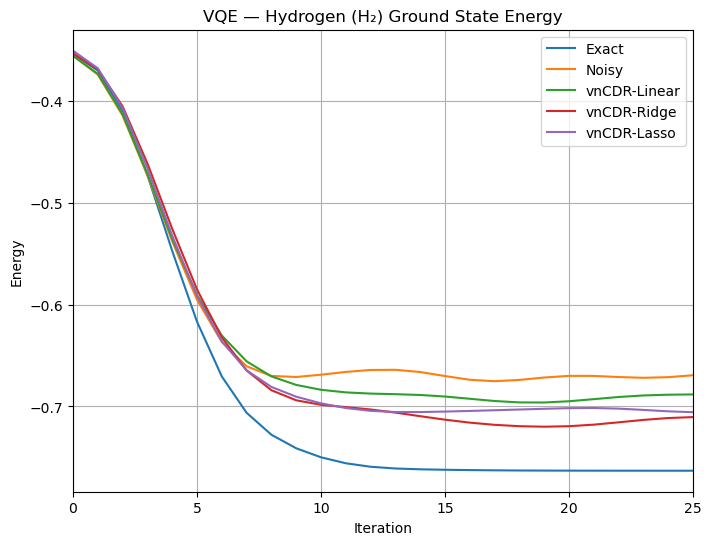

In [18]:
from scipy.ndimage import gaussian_filter1d

ysmoothed_exact  = gaussian_filter1d(history_exact,         sigma = 2)
ysmoothed_noisy  = gaussian_filter1d(history_noisy,         sigma = 2)


plt.figure(figsize=(8,6))
plt.plot(ysmoothed_exact[:26],  label="Exact")
plt.plot(ysmoothed_noisy[:26],  label="Noisy")
plt.plot(smooth(mean_lin[:26]),   label="vnCDR-Linear")
plt.plot(smooth(mean_ridge[:26]), label="vnCDR-Ridge")
plt.plot(smooth(mean_lasso[:26]), label="vnCDR-Lasso")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title(f"VQE — Hydrogen (H₂) Ground State Energy")
plt.grid(True)
plt.legend()
plt.xlim(0, 25)
plt.savefig('Full_VQE.png', dpi=600)
plt.show()

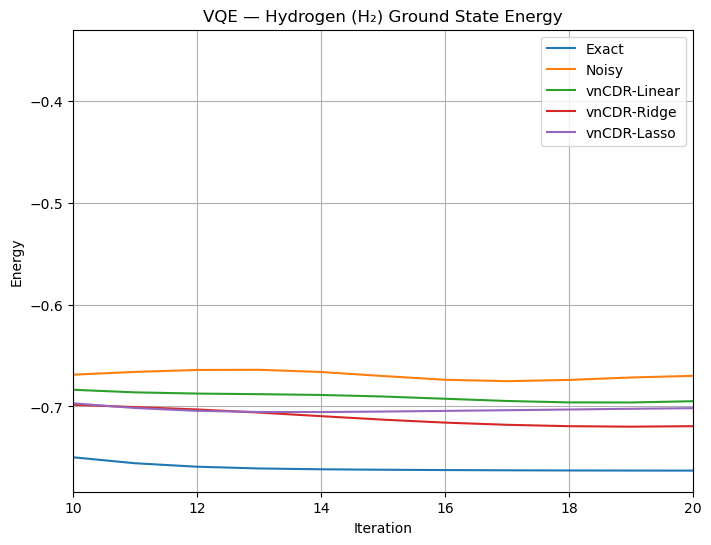

In [19]:
iterations = np.arange(10, 21)

plt.figure(figsize=(8,6))
plt.plot(ysmoothed_exact,  label="Exact")
plt.plot(ysmoothed_noisy,  label="Noisy")
plt.plot(smooth(mean_lin),   label="vnCDR-Linear")
plt.plot(smooth(mean_ridge), label="vnCDR-Ridge")
plt.plot(smooth(mean_lasso), label="vnCDR-Lasso")

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE — Hydrogen (H₂) Ground State Energy")
plt.legend()
plt.grid(True)
plt.xlim(10, 20)
plt.savefig('Plot10to20_VQE.png', dpi=600)
plt.show()

In [20]:
##############################################################################
# build metrics table for averaged cdr runs
##############################################################################

def last_energies(run_list):
    # return the final energy of every single optimisation in run_list
    return [hist[-1] for hist in run_list if len(hist)]

mean_final_lin   = mean_lin[26]
mean_final_ridge = mean_ridge[26]
mean_final_lasso = mean_lasso[26]

# histories and final energies
candidates = [
    ("exact",                history_exact, history_exact[26]),
    ("noisy",                history_noisy, history_exact[26]),
    (f"cdr-linear⟨{n_runs}⟩", mean_lin,      mean_final_lin),
    (f"cdr-ridge⟨{n_runs}⟩",  mean_ridge,    mean_final_ridge),
    (f"cdr-lasso⟨{n_runs}⟩",  mean_lasso,    mean_final_lasso),
]

# helpers
def series_error(hist_model, hist_exact):
    m = min(len(hist_model), len(hist_exact))
    err = np.abs(np.asarray(hist_model[:m]) - np.asarray(hist_exact[:m]))
    return err[~np.isnan(err)]  # drop nans from padding

def first_below(err_series, thresh = 1e-3):
    idx = np.where(err_series < thresh)[0]
    return int(idx[0]) if idx.size else None

# assemble the dataframe
records = []
for tag, hist, e_final in candidates:
    err = series_error(hist, history_exact)
    records.append({
        "method"         : tag,
        "final_energy"   : e_final,
        "|Δe|_final"     : abs(e_final - res_exact.fun),
        "|Δe|_mean"      : err.mean(),
        "auc_|Δe|"       : err.sum()
    })

df = (pd.DataFrame(records)
        .set_index("method")
        .sort_values("|Δe|_final"))

# percent improvement vs single noisy run
noise_mean = df.loc["noisy", "|Δe|_mean"]
df["mean % improvement"] = 100 * (noise_mean - df["|Δe|_mean"]) / noise_mean

# display
try:
    import ace_tools as tools
    tools.display_dataframe_to_user("cdr-metrics (averaged)", df.round(6))
except ModuleNotFoundError:
    print(df.round(6))

                      Final_Energy              |ΔE|_Final  |ΔE|_Mean  \
Method                                                                  
Exact          -0.7630922790812452  2.6302424424029525e-05   0.000000   
Noisy          -0.7630922790812452  2.6302424424029525e-05   0.073952   
CDR-Lasso⟨5⟩             -0.727233                0.035886   0.050112   
CDR-Ridge⟨5⟩             -0.711285                0.051834   0.047926   
CDR-Linear⟨5⟩             -0.67984                0.083278   0.061827   

               AUC_|ΔE|  Mean % Improvement  
Method                                       
Exact          0.000000          100.000000  
Noisy          2.070647            0.000000  
CDR-Lasso⟨5⟩   1.854138           32.237046  
CDR-Ridge⟨5⟩   1.677423           35.192299  
CDR-Linear⟨5⟩  1.978471           16.395102  
